In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

In [226]:
# experiment_id = mlflow.create_experiment("xgboost_projet_appli_ia")

In [147]:
df_train_modify = pd.read_csv('../../csv/train_modifie.csv')
df_test_modify = pd.read_csv('../../csv/test_modifie.csv')

In [148]:
df_train = df_train_modify.drop(['day_length'], axis=1)
df_test = df_test_modify.drop(['day_length'], axis=1)

In [143]:
X_train = df_train.drop(['registered', 'casual'], axis=1)
y_train_registered = df_train['registered']
y_train_casual = df_train['casual']

X_test = df_test.drop(['registered', 'casual'], axis=1)
y_test_registered = df_test['registered']
y_test_casual = df_test['casual']

In [125]:
X_train_registered, _, y_train_registered, _ = train_test_split(X_train, y_train_registered, test_size=0.00001)
X_train_casual, _, y_train_casual, _ = train_test_split(X_train, y_train_casual, test_size=0.00001, random_state=42)

# Preprocessing

In [126]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

def metrics_scores(y, y_pred):
    print('MSE test : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE test : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE test : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE test : ' + str(median_absolute_error(y, y_pred)))

def metrics_scores_train(y, y_pred):
    print('MSE train : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE train : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE train : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE testraint : ' + str(median_absolute_error(y, y_pred)))

In [127]:
encoded_features = ['season', 'weather', 'week_days', 'months']
ohe = make_column_transformer((OneHotEncoder(),encoded_features), remainder='passthrough')
ohe.fit(X_train_registered)
X_train_ohe = ohe.transform(X_train_registered)
X_train_registered = pd.DataFrame(X_train_ohe)

ohe.fit(X_train_casual)
X_train_ohe = ohe.transform(X_train_casual)
X_train_casual = pd.DataFrame(X_train_ohe)

X_test_ohe = ohe.transform(X_test)
X_test = pd.DataFrame(X_test_ohe)

In [128]:
features_name = {}
for i in range(X_train_registered.shape[1]):
    features_name[i] = ohe.get_feature_names_out()[i].replace("onehotencoder__","").replace("remainder__","")
X_train_registered = X_train_registered.rename(columns=features_name)
X_train_casual = X_train_casual.rename(columns=features_name)
X_test = X_test.rename(columns=features_name)

In [129]:
#Features et pipelines
scaled_features = ['temp', 'atemp', 'windspeed', 'humidity', 'hours']#, 'day_length'
scaled_pipeline = make_pipeline(StandardScaler())

#preprocessing et main pipeline
params = {'n_estimators': 195, 'max_depth': 8, 'subsample': 0.8, 'learning_rate': 0.1,
          'colsample_bytree':0.9, 'colsample_bylevel': 1, 'colsample_bynode': 1,
          'gamma': 0}
preprocessor = make_column_transformer((scaled_pipeline, scaled_features), remainder="passthrough")
xgb = XGBRegressor(n_estimators=125, max_depth=7, subsample=0.8, learning_rate=0.1,
                   colsample_bytree=0.9, colsample_bylevel=1, colsample_bynode=1,
                   gamma=0)
model_registered = make_pipeline(preprocessor, xgb)

{'xgbregressor__colsample_bylevel': 1,
 'xgbregressor__colsample_bynode': 1,
 'xgbregressor__colsample_bytree': 0.9,
 'xgbregressor__gamma': 0.0,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 195,
 'xgbregressor__subsample': 0.8}

## Modélisation registered

In [11]:
parameters = {'xgbregressor__n_estimators': np.arange(190,201,5),
              'xgbregressor__max_depth': [8],
              'xgbregressor__learning_rate':[0.1],
              'xgbregressor__subsample': [0.8,0.9,1],
              'xgbregressor__colsample_bytree': [0.7,0.8,0.9],
              'xgbregressor__colsample_bylevel': [0.8,0.9,1],
              'xgbregressor__colsample_bynode': [0.8,0.9,1],
              'xgbregressor__gamma': np.arange(0,0.2,0.1)}

grid = GridSearchCV(model_registered, parameters,cv=5)
grid.fit(X_train_registered, y_train_registered)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'atemp',
                                                                          'windspeed',
                                                                          'humidity',
                                                                          'hours'])])),
                                       ('xgbregressor',
                                        XGBRegresso

In [12]:
grid.best_params_

{'xgbregressor__colsample_bylevel': 1,
 'xgbregressor__colsample_bynode': 1,
 'xgbregressor__colsample_bytree': 0.9,
 'xgbregressor__gamma': 0.0,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 195,
 'xgbregressor__subsample': 0.8}

In [130]:
# mlflow.sklearn.autolog()

# with mlflow.start_run(experiment_id = 1):

metrics = ['r2','neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error',
        'neg_median_absolute_error']#, 'neg_mean_squared_log_error'
scores = cross_validate(model_registered,X_train_registered,y_train_registered,cv=5,scoring=metrics)

print(scores['test_r2'])
r2 = np.nanmean(scores['test_r2'])
r2_adj = adjustedR2(r2,X_train_registered.shape[0],X_train_registered.shape[1])
mse = np.nanmean(-scores['test_neg_mean_squared_error'])
rmse = np.nanmean(-scores['test_neg_root_mean_squared_error'])
mae = np.nanmean(-scores['test_neg_mean_absolute_error'])
mdae = np.nanmean(-scores['test_neg_median_absolute_error'])
print('r2 : ' + str(r2))
print('r2 adj. : ' + str(r2_adj))
print('MSE : ' + str(mse))
print('RMSE : ' + str(rmse))
print('MAE : ' + str(mae))
print('MdAE : ' + str(mdae))
print('------------------------------------------------')
""" Valeurs par défaut : 
- n_estimators = 1
- max_depth = 6
- learning_rate = 0.3
- gamma = 0
- subsample = 1
- colsample_bytree,  colsample_bylevel, colsample_bynode = 1
"""
        # mlflow.log_param("registered n_estimators", 1)
        # mlflow.log_param("registered max_depth", 6)
        # mlflow.log_param("registered learning_rate", 0.3)
        # mlflow.log_param("registered gamma", 0)
        # mlflow.log_param("registered subsample", 1)
        # mlflow.log_param("registered colsample_bylevel", 1)
        # mlflow.log_param("registered colsample_bynode", 1)
        # mlflow.log_param("registered colsample_bytree", 1)

        # mlflow.log_metric("registered r2", r2)
        # mlflow.log_metric("registered r2 adj.", r2_adj)
        # mlflow.log_metric("registered MSE", mse)
        # mlflow.log_metric("registered RMSE", rmse)
        # mlflow.log_metric("registered MAE", mae) 
        # mlflow.log_metric("registered MdAE", mdae) 

        # r2 = model.score(X_test, y_test_registered)
        # y_pred_registered = model.predict(X_test)
        # print('r2 : ' + str(r2))
        # print('r2 adj. : ' + str(adjustedR2(r2,X_train.shape[0],X_train.shape[1])))
        # metrics_scores(y_test_registered,y_pred_registered)

[0.96033458 0.95470639 0.95170195 0.95331553 0.95440534]
r2 : 0.9548927567136907
r2 adj. : 0.954722408355173
MSE : 880.2444217925006
RMSE : 29.6542710732829
MAE : 18.026780767607054
MdAE : 10.528183937072754
------------------------------------------------


' Valeurs par défaut : \n- n_estimators = 1\n- max_depth = 6\n- learning_rate = 0.3\n- gamma = 0\n- subsample = 1\n- colsample_bytree,  colsample_bylevel, colsample_bynode = 1\n'

In [102]:
N, train_score, val_score = learning_curve(model_registered, X_train_registered, y_train_registered, train_sizes=np.linspace(0.1,1,20))

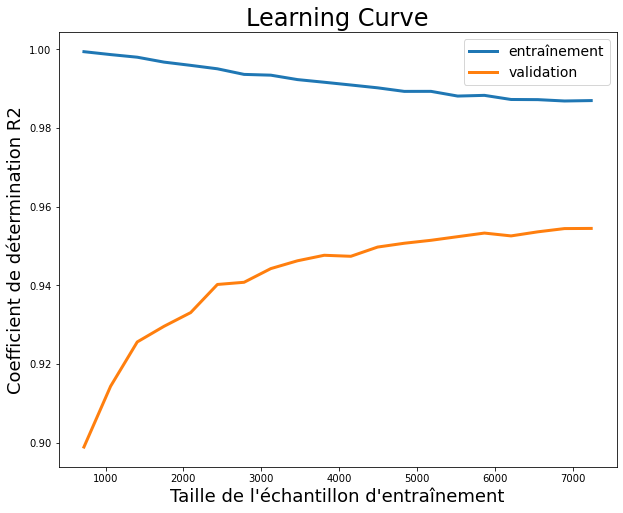

In [105]:
plt.figure(figsize=(10,8))
plt.plot(N,train_score.mean(axis=1),lw=3,label='entraînement')
plt.plot(N,np.nanmean(val_score,axis=1),lw=3,label='validation')
plt.title('Learning Curve',fontsize=24)
plt.xlabel('Taille de l\'échantillon d\'entraînement',fontsize=18)
plt.ylabel('Coefficient de détermination R2',fontsize=18)
plt.legend(fontsize=14)

In [131]:
model_registered.fit(X_train_registered,y_train_registered)
model_registered.predict(X_test)
model_registered.score(X_test,y_test_registered)

0.863209531391531

In [120]:
import pickle
  
with open('../../app/model_registered.pkl', 'wb') as file:
    pickle.dump(model_registered, file)

## Modélisation casual

In [132]:
#Features et pipelines
scaled_features = ['temp', 'atemp', 'windspeed', 'humidity', 'hours']#, 'day_length'
scaled_pipeline = make_pipeline(StandardScaler())

#preprocessing et main pipeline
params = {'n_estimators': 105, 'max_depth': 8, 'subsample': 0.8, 'learning_rate': 0.1,
          'colsample_bytree':0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.4,
          'gamma': 0}
preprocessor = make_column_transformer((scaled_pipeline, scaled_features), remainder="passthrough")
xgb = XGBRegressor(n_estimators=140, max_depth=7, subsample=0.9, learning_rate=0.1,
          colsample_bytree=0.9, colsample_bylevel=0.8, colsample_bynode=0.9,
          gamma=0.1)
model_casual = make_pipeline(preprocessor, xgb)

{'xgbregressor__colsample_bylevel': 0.8,
 'xgbregressor__colsample_bynode': 0.9,
 'xgbregressor__colsample_bytree': 0.9,
 'xgbregressor__gamma': 0.1,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 140,
 'xgbregressor__subsample': 0.9}

In [36]:
parameters = {'xgbregressor__n_estimators': np.arange(135,146,5),
              'xgbregressor__max_depth': np.arange(7,9,1),
              'xgbregressor__learning_rate':[0.1],
              'xgbregressor__subsample': [0.8,0.9,1],
              'xgbregressor__colsample_bytree': [0.8,0.9,1],
              'xgbregressor__colsample_bylevel': [0.8,0.9,1],
              'xgbregressor__colsample_bynode': [0.8,0.9,1],
              'xgbregressor__gamma': [0,0.1,0.2]}

grid = GridSearchCV(model_casual, parameters,cv=5)
grid.fit(X_train_casual, y_train_casual)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'atemp',
                                                                          'windspeed',
                                                                          'humidity',
                                                                          'hours'])])),
                                       ('xgbregressor',
                                        XGBRegresso

In [38]:
grid.best_params_

{'xgbregressor__colsample_bylevel': 0.8,
 'xgbregressor__colsample_bynode': 0.9,
 'xgbregressor__colsample_bytree': 0.9,
 'xgbregressor__gamma': 0.1,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 140,
 'xgbregressor__subsample': 0.9}

In [133]:
# with mlflow.start_run(experiment_id = 1):

metrics = ['r2','neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','neg_median_absolute_error']
scores = cross_validate(model_casual,X_train_casual,y_train_casual,cv=5,scoring=metrics)

print(scores['test_r2'])
r2 = np.nanmean(scores['test_r2'])
print('r2 : ' + str(r2))
print('r2 adj. : ' + str(adjustedR2(r2,X_train_casual.shape[0],X_train_casual.shape[1])))
print('MSE : ' + str(np.nanmean(-scores['test_neg_mean_squared_error'])))
print('RMSE : ' + str(np.nanmean(-scores['test_neg_root_mean_squared_error'])))
print('MAE : ' + str(np.nanmean(-scores['test_neg_mean_absolute_error'])))
print('MdAE : ' + str(np.nanmean(-scores['test_neg_median_absolute_error'])))
# print('------------------------------------------------')
""" Valeurs par défaut : 
    - n_estimators = 1
    - max_depth = 6
    - learning_rate = 0.3
    - gamma = 0
    - subsample = 1
    - colsample_bytree,  colsample_bylevel, colsample_bynode = 1
"""
    # mlflow.log_param("casual n_estimators", 1)
    # mlflow.log_param("casual max_depth", 6)
    # mlflow.log_param("casual learning_rate", 0.3)
    # mlflow.log_param("casual gamma", 0)
    # mlflow.log_param("casual subsample", 1)
    # mlflow.log_param("casual colsample_bylevel", 1)
    # mlflow.log_param("casual colsample_bynode", 1)
    # mlflow.log_param("casual colsample_bytree", 1)

    # mlflow.log_metric("casual r2", r2)
    # mlflow.log_metric("casual r2 adj.", r2_adj)
    # mlflow.log_metric("casual MSE", mse)
    # mlflow.log_metric("casual RMSE", rmse)
    # mlflow.log_metric("casual MAE", mae) 
    # mlflow.log_metric("casual MdAE", mdae) 

    # r2 = model.score(X_test, y_test_casual)

    # print('r2 : ' + str(r2))
    # print('r2 adj. : ' + str(adjustedR2(r2,X_train.shape[0],X_train.shape[1])))
    # metrics_scores(y_test_casual,y_pred_casual)
    # residus_test = y_pred-y_train_casual
    # y_pred_casual = model.predict(X_test)

[0.92704647 0.92470129 0.92959744 0.93682794 0.93799724]
r2 : 0.9312340760730059
r2 adj. : 0.9309743802589975
MSE : 164.24306865110398
RMSE : 12.797688103904111
MAE : 7.689968435797953
MdAE : 3.9621209569275377


' Valeurs par défaut : \n    - n_estimators = 1\n    - max_depth = 6\n    - learning_rate = 0.3\n    - gamma = 0\n    - subsample = 1\n    - colsample_bytree,  colsample_bylevel, colsample_bynode = 1\n'

In [113]:
N, train_score, val_score = learning_curve(model_casual, X_train_casual, y_train_casual, train_sizes=np.linspace(0.1,1,20))

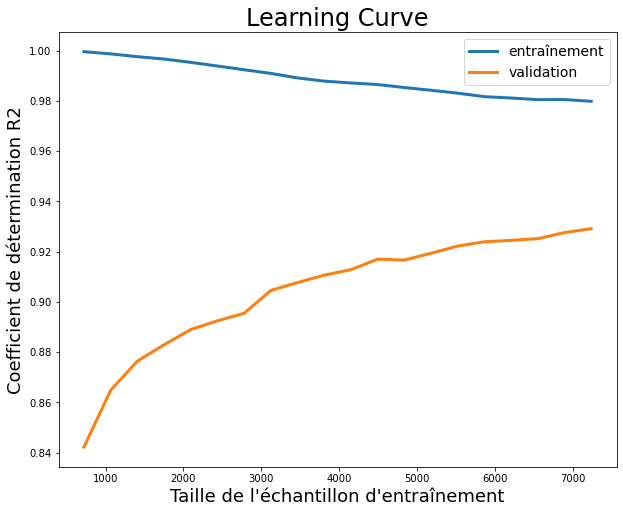

In [114]:
plt.figure(figsize=(10,8))
plt.plot(N,train_score.mean(axis=1),lw=3,label='entraînement')
plt.plot(N,np.nanmean(val_score,axis=1),lw=3,label='validation')
plt.title('Learning Curve',fontsize=24)
plt.xlabel('Taille de l\'échantillon d\'entraînement',fontsize=18)
plt.ylabel('Coefficient de détermination R2',fontsize=18)
plt.legend(fontsize=14)

In [134]:
model_casual.fit(X_train_casual,y_train_casual)
model_casual.predict(X_test)
model_casual.score(X_test,y_test_casual)

0.8695830812618919

In [116]:
import pickle
  
with open('../../app/model_casual.pkl', 'wb') as file:
    pickle.dump(model_casual, file)

In [899]:
df_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,day_length,months,hours,years,week_days
0,4,0,0,1,9.84,14.395,81,0.0000,3,13,34377.0,1,0,2011,6
1,4,0,0,1,9.02,13.635,80,0.0000,8,32,34377.0,1,1,2011,6
2,4,0,0,1,9.02,13.635,80,0.0000,5,27,34377.0,1,2,2011,6
3,4,0,0,1,9.84,14.395,75,0.0000,3,10,34377.0,1,3,2011,6
4,4,0,0,1,9.84,14.395,75,0.0000,0,1,34377.0,1,4,2011,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9034,2,0,0,2,26.24,30.305,73,8.9981,72,269,48944.0,8,19,2012,7
9035,2,0,0,2,26.24,30.305,73,12.9980,61,213,48944.0,8,20,2012,7
9036,2,0,0,3,25.42,29.545,78,6.0032,36,154,48944.0,8,21,2012,7
9037,2,0,0,2,25.42,29.545,78,11.0014,6,50,48944.0,8,22,2012,7
